In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [57]:
DATA_FILE = '../input/spam.csv'
df = pd.read_csv(DATA_FILE,encoding='latin-1')

# drop extraneous columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
print(df.head())

labels = df.v1
messages = df.v2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
print('\nimport done')

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

import done


In [58]:
# rename the column names to label and text
df = df.rename(columns={"v1": "label", "v2":"text"})
print(df.head())
df.label.value_counts()

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


ham     4825
spam     747
Name: label, dtype: int64

In [59]:
df['msgLen'] = df['text'].map(lambda x:len(x))
print(df.describe())
mean = df['msgLen'].mean()
std = df['msgLen'].std()
print(mean)
print(std)
print("\n\nDetected outliers")

outlierCount = 0
for message in df['text']:
    # printing the length of the outliers, can comment out if desired
    if len(message) < mean - 2*std:
        print(len(message))
    elif len(message) > mean + 2*std:
        print(len(message))
    else:
        outlierCount -= 1
    outlierCount += 1
    
print("There were %d outliers" %outlierCount)

            msgLen
count  5572.000000
mean     80.118808
std      59.690841
min       2.000000
25%      36.000000
50%      61.000000
75%     121.000000
max     910.000000
80.11880832735105
59.6908407765031


Detected outliers
291
244
384
232
202
300
221
204
248
298
281
269
226
215
372
231
276
221
220
210
224
910
327
207
203
278
458
212
611
338
224
205
332
790
431
375
276
363
382
588
281
450
482
444
632
235
201
245
306
202
289
243
444
200
588
276
234
327
269
461
295
242
297
281
444
320
368
274
287
322
293
263
302
204
244
257
205
202
220
255
276
230
263
290
329
408
283
200
381
278
237
236
205
208
229
237
240
201
299
276
415
237
247
256
450
281
228
329
278
212
251
245
329
273
There were 114 outliers


In [60]:
spam = df[df.label == 'spam']
ham = df[df.label == 'ham']

from keras.preprocessing.text import text_to_word_sequence

def wordFreqs(text):
    msgs = {}
    for msg in text:
        words = text_to_word_sequence(msg)
        for word in words:
            # try and get more significant words
            if len(word) > 3:
                try:
                    msgs[word] += 1
                except:
                    msgs[word] = 1
    return msgs

spamDict = wordFreqs(spam.text)
hamDict = wordFreqs(ham.text)



In [61]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# # vectorizer = CountVectorizer()
# # vectorizer.fit(spam.text)

# spamVectorizer = TfidfVectorizer()
# spamVectorizer.fit(spam.text)
# spamDict = spamVectorizer.vocabulary_
# # print(vectorizer.vocabulary_)

# hamVectorizer = TfidfVectorizer()
# hamVectorizer.fit(ham.text)
# hamDict = hamVectorizer.vocabulary_

In [62]:
# Benchmark
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df["label"])

X_train,X_test,y_train,y_test = train_test_split(df["text"], y, test_size = 0.2, random_state = 10)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_df = vectorizer.transform(X_train)
X_test_df = vectorizer.transform(X_test)

# lb = preprocessing.LabelBinarizer()
# lb.fit(y_train)

model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train_df, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [63]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing
prediction = model.predict(X_test_df)
print('Accuracy score: {}'.format(accuracy_score(y_test, prediction)))
print('F1 score: {}'.format(f1_score(y_test, prediction)))

Accuracy score: 0.9040358744394619
F1 score: 0.4455958549222798


<built-in method sum of numpy.ndarray object at 0x7f9ee47f26c0>


Text(0.5,15,'Predicted label')

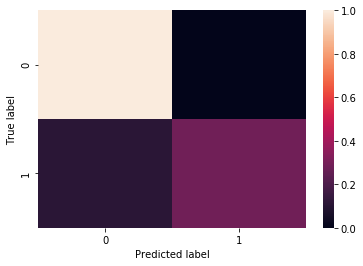

In [64]:
# referenced https://www.kaggle.com/futurist/text-preprocessing-and-machine-learning-modeling
from sklearn.metrics import confusion_matrix, classification_report
import seaborn
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, prediction)
print(cm.sum)
cm_norm = cm.astype('float') / cm.sum(axis=1)[np.newaxis]
seaborn.heatmap(cm_norm)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spamWordcloud = WordCloud(width=600,height=400, max_words=1000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(spamDict)
hamWordcloud = WordCloud(width=600,height=400, max_words=1000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(hamDict)

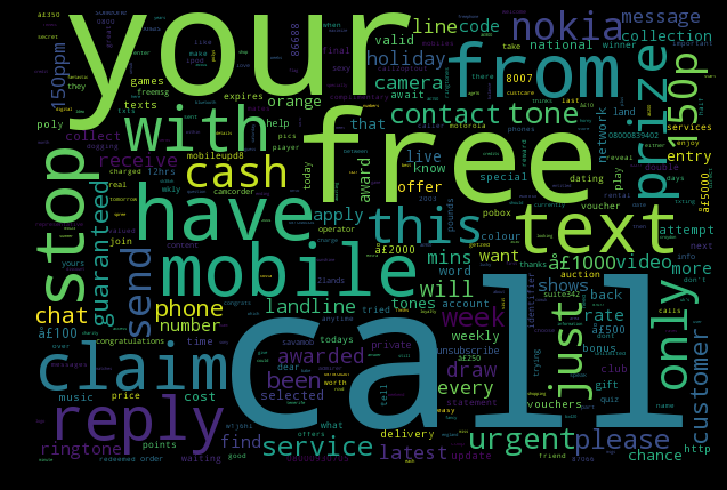

In [66]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spamWordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

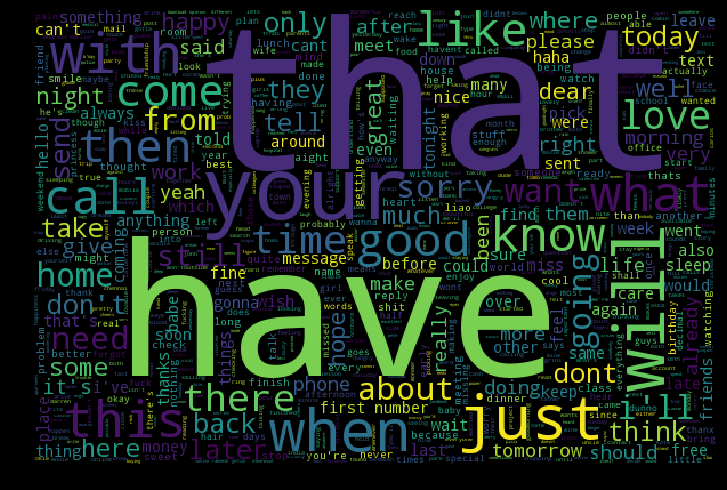

In [67]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(hamWordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [68]:
max_words = 1000
num_max = max_words
# preprocess
le = LabelEncoder()
labels = le.fit_transform(labels)
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(messages)
mat_texts = tok.texts_to_matrix(messages,mode='count')
print(labels[:5])
print(mat_texts[:5])
print(labels.shape,mat_texts.shape)

[0 0 1 0 0]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  3. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  0.  0.  0.]]
(5572,) (5572, 1000)


In [69]:
# from iPython.display import clear_output
import keras
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
#         clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [70]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
#         clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [71]:
# https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [72]:
def check_model(model,x,y):
#     print(x)
#     print(y)
    train_test_split(x, y, stratify = y)
    hist = model.fit(x,y,batch_size=32,epochs=2,verbose=1,validation_split=0.3,callbacks=[plot])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_40 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
Train on 3900 samples, validate on 1672 samples
Epoch 1/2
3744/3900 [===========================>..] - ETA: 0s - loss: 0.1735 - f1: nan

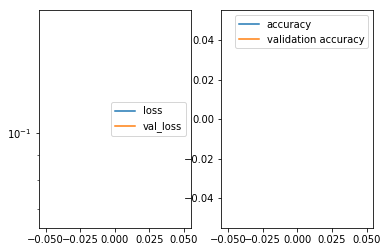

3900/3900 [==============================] - 5s 1ms/step - loss: 0.1689 - f1: nan - val_loss: 0.0671 - val_f1: 0.9440
Epoch 2/2
3872/3900 [============================>.] - ETA: 0s - loss: 0.0326 - f1: nan

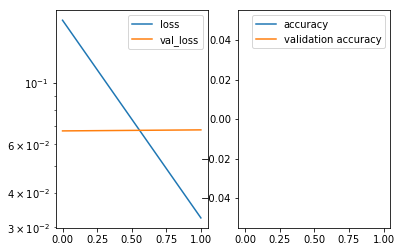

3900/3900 [==============================] - 3s 877us/step - loss: 0.0325 - f1: nan - val_loss: 0.0677 - val_f1: 0.9430


In [73]:
# try a simple model first
from keras import metrics

def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
                metrics=[f1])
#               metrics=['acc',metrics.binary_accuracy])
    return model

m = get_simple_model()
check_model(m,mat_texts,labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_42 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 129       
Total para

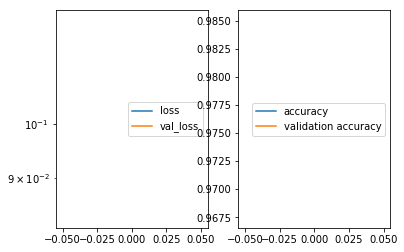

3900/3900 [==============================] - 4s 1ms/step - loss: 0.1224 - acc: 0.9674 - binary_accuracy: 0.9674 - f1: nan - val_loss: 0.0832 - val_acc: 0.9850 - val_binary_accuracy: 0.9850 - val_f1: 0.9389
Epoch 2/2
3872/3900 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9925 - binary_accuracy: 0.9925 - f1: nan

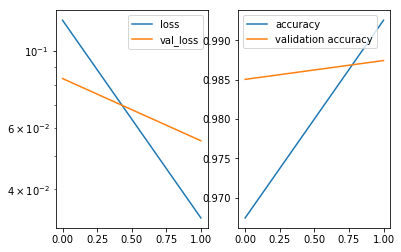

3900/3900 [==============================] - 3s 727us/step - loss: 0.0331 - acc: 0.9926 - binary_accuracy: 0.9926 - f1: nan - val_loss: 0.0552 - val_acc: 0.9874 - val_binary_accuracy: 0.9874 - val_f1: 0.9476


In [74]:
def get_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=['acc',metrics.binary_accuracy,f1])
    return model

m = get_model()
check_model(m,mat_texts,labels)